In [1]:
##Rebecca Lewis
#DSC 630
#cat BinaryClassModel

In [2]:
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from matplotlib import pyplot as plt
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#https://elitedatascience.com/imbalanced-classes
    
#upsample with logistic regression
#downsample with logistic regression
#penalized svm
#randomforest

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#read in data files
catdata = pd.read_csv('Project_R_scripts\catdata.csv') 

In [4]:
catdata.columns

#remove outcome weekday when creating features
cat_columns = ['IntakeMonth', 'IntakeWeekday', 'Log10AgeInMonths',
       'Male', 'AsilomarImprovement', 'HealthyAsilomar', 'TreatRehabAsilomar',
       'TreatManAsilomar', 'UnhealthyAsilomar', 'Emaciated', 'Feral',
       'SickInjured', 'SkinIssue', 'SurrenderIntake', 'SeizeCustodyIntake',
       'StrayIntake', 'TransferIntake', 'SmallAnimal', 'AlteredAtIntake',
       'Foster', 'Offsite', 'CatBreedSpecified']

cat_features = catdata[cat_columns]
cat_target = catdata['AdoptedInSevenDays']


In [5]:
#split into train and testing sets
cat_X_train, cat_X_test, cat_y_train, cat_y_test = train_test_split(cat_features, cat_target, 
                                                                    test_size =0.33, random_state=0, stratify=cat_target)
# number of samples in each set
print("No. of samples in training set: ", cat_X_train.shape[0])
print("No. of samples in validation set:", cat_X_test.shape[0])

No. of samples in training set:  1779
No. of samples in validation set: 877


In [6]:
#cat upsampling
# combine the features and target for the training set
#only upsampling the training dataset
cat_training = pd.concat([cat_X_train, cat_y_train], axis=1)

In [7]:
cat_training['AdoptedInSevenDays'].value_counts()

0    1616
1     163
Name: AdoptedInSevenDays, dtype: int64

In [8]:
cat_majority = cat_training[cat_training.AdoptedInSevenDays==0]
cat_minority = cat_training[cat_training.AdoptedInSevenDays==1]

In [9]:
# Upsample minority class
cat_minority_upsampled = resample(cat_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=3179,    # to match majority class
                                 random_state=0) # reproducible results

In [10]:
# Combine majority class with upsampled minority class
cat_training_upsampled = pd.concat([cat_majority, cat_minority_upsampled])

In [11]:
# Display new class counts
cat_training_upsampled.AdoptedInSevenDays.value_counts()

1    3179
0    1616
Name: AdoptedInSevenDays, dtype: int64

In [12]:
cat_upsampled_target = cat_training_upsampled['AdoptedInSevenDays']
cat_upsampled_features = cat_training_upsampled.drop("AdoptedInSevenDays", axis=1)

In [13]:
from sklearn.preprocessing import StandardScaler

reg = LogisticRegression()
scaler = StandardScaler()

scaledfeatures = scaler.fit_transform(cat_upsampled_features)

# Train model

 
cat_upsample_model = reg.fit(scaledfeatures, cat_upsampled_target)


In [14]:
scaledtestfeatures = scaler.transform(cat_X_test)

# Predict on training set
cat_upsample_pred = cat_upsample_model.predict(scaledtestfeatures)

In [15]:
print(metrics.accuracy_score(cat_upsample_pred, cat_y_test) )
print(metrics.recall_score(cat_upsample_pred, cat_y_test) )

0.6009122006841505
0.17073170731707318


In [16]:
print(metrics.classification_report(cat_upsample_pred, cat_y_test) )

              precision    recall  f1-score   support

           0       0.57      0.98      0.72       467
           1       0.88      0.17      0.29       410

    accuracy                           0.60       877
   macro avg       0.72      0.57      0.50       877
weighted avg       0.71      0.60      0.52       877



In [17]:
#get predicted probabilites for roc score
prob_upsample_y = cat_upsample_model.predict_proba(scaledfeatures)
 
# Keep only the positive class
prob_upsample_y = [p[1] for p in prob_upsample_y]

print(metrics.roc_auc_score(cat_upsampled_target, prob_upsample_y) )

0.838887100215212


C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


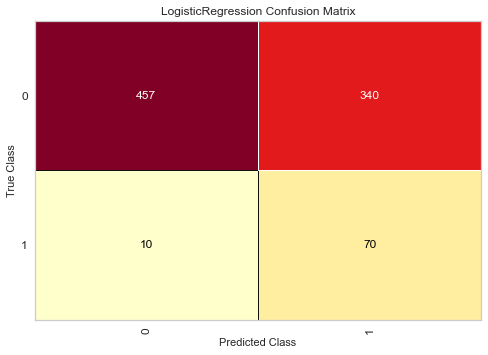

In [18]:
cm = ConfusionMatrix(reg)
cm.fit(scaledfeatures, cat_upsampled_target)
cm.score(scaledtestfeatures, cat_y_test)
cm.show()

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


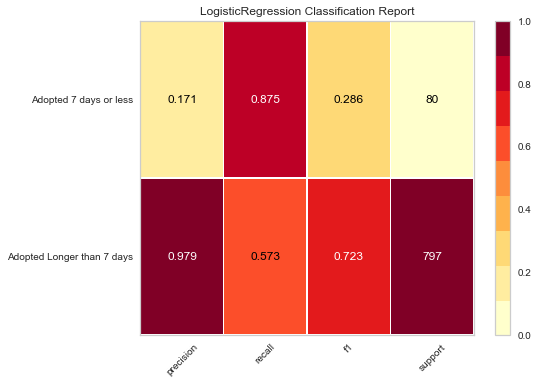

In [19]:
visualizer = ClassificationReport(reg, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'], support=True)

visualizer.fit(scaledfeatures, cat_upsampled_target)        # Fit the visualizer and the model
visualizer.score(scaledtestfeatures, cat_y_test)        # Evaluate the model on the test data
visualizer.show() 

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


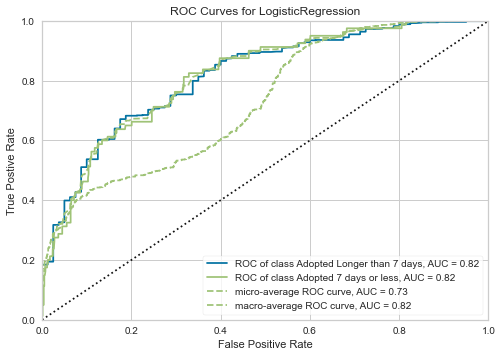

In [20]:
visualizer = ROCAUC(reg, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'])

visualizer.fit(scaledfeatures, cat_upsampled_target)        # Fit the visualizer and the model
visualizer.score(scaledtestfeatures, cat_y_test)        # Evaluate the model on the test data
visualizer.show() 

In [21]:
#downsample majority
# Downsample majority class
cat_majority_downsampled = resample(cat_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=449,     # to match minority class
                                 random_state=0) # reproducible results
 
# Combine minority class with downsampled majority class
cat_train_downsampled = pd.concat([cat_majority_downsampled, cat_minority])
 
# Display new class counts
cat_train_downsampled.AdoptedInSevenDays.value_counts()

0    449
1    163
Name: AdoptedInSevenDays, dtype: int64

In [22]:
cat_downsampled_target = cat_train_downsampled['AdoptedInSevenDays']
cat_downsampled_features = cat_train_downsampled.drop("AdoptedInSevenDays", axis=1)

In [23]:
reg = LogisticRegression()
scaler = StandardScaler()

scaledfeatures = scaler.fit_transform(cat_downsampled_features)

# Train model
cat_downsample_model = reg.fit(scaledfeatures, cat_downsampled_target)

scaledtestfeatures = scaler.transform(cat_X_test)

# Predict on testing set
cat_downsample_pred = cat_downsample_model.predict(scaledtestfeatures)
print(metrics.accuracy_score(cat_downsample_pred, cat_y_test) )
print(metrics.recall_score(cat_downsample_pred, cat_y_test) )

0.863169897377423
0.3181818181818182


In [24]:
print(metrics.classification_report(cat_downsample_pred, cat_y_test) )

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       767
           1       0.44      0.32      0.37       110

    accuracy                           0.86       877
   macro avg       0.67      0.63      0.65       877
weighted avg       0.85      0.86      0.85       877



C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


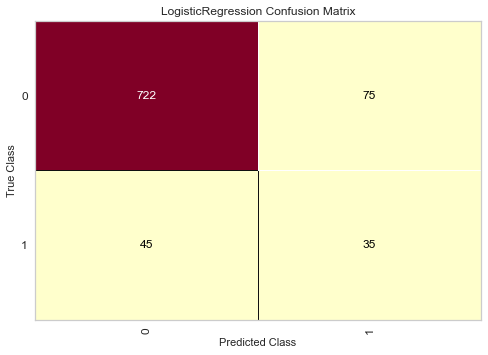

In [25]:
cm = ConfusionMatrix(reg)
cm.fit(scaledfeatures, cat_downsampled_target)
cm.score(scaledtestfeatures, cat_y_test)
cm.show()

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


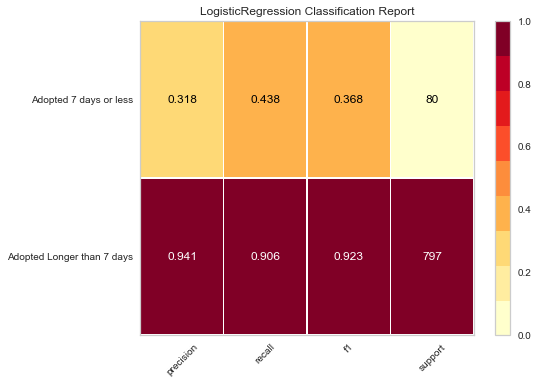

In [26]:
visualizer = ClassificationReport(reg, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'], support=True)

visualizer.fit(scaledfeatures, cat_downsampled_target)        # Fit the visualizer and the model
visualizer.score(scaledtestfeatures, cat_y_test)        # Evaluate the model on the test data
visualizer.show() 

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


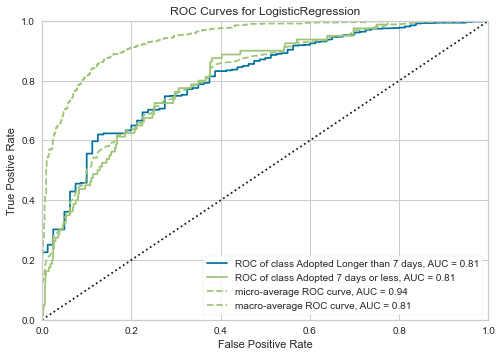

In [27]:
visualizer = ROCAUC(reg, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'])

visualizer.fit(scaledfeatures, cat_downsampled_target)        # Fit the visualizer and the model
visualizer.score(scaledtestfeatures, cat_y_test)        # Evaluate the model on the test data
visualizer.show() 

In [28]:
#get predicted probabilites for roc score
prob_downsample_y = cat_downsample_model.predict_proba(scaledfeatures)
 
# Keep only the positive class
prob_downsample_y = [p[1] for p in prob_downsample_y]
 
prob_downsample_y[:5]

[0.005344164909873392,
 0.11625205576876944,
 0.06355071354610752,
 0.12559419361273666,
 0.08237829710690457]

In [29]:
print( roc_auc_score(cat_downsampled_target, prob_downsample_y) )

0.8569418066049983


In [30]:
##Penalized Classes

# Train model
cat_svc_model = SVC(kernel='linear', 
            class_weight='balanced', # penalize
            probability=True)
 
cat_svc_model.fit(cat_X_train, cat_y_train)
 
# Predict on training set
cat_svc_pred = cat_svc_model.predict(cat_X_test)
 
# Is our model still predicting just one class?
print( np.unique( cat_svc_pred ) )

print( metrics.accuracy_score(cat_y_test, cat_svc_pred) )
print( metrics.recall_score(cat_y_test, cat_svc_pred) )

cat_prob_svc = cat_svc_model.predict_proba(cat_X_test)
cat_prob_svc = [p[1] for p in cat_prob_svc]
print( roc_auc_score(cat_y_test, cat_prob_svc) )


[0 1]
0.6807297605473204
0.75
0.8015840652446675


In [31]:
print(metrics.classification_report(cat_svc_pred, cat_y_test) )

              precision    recall  f1-score   support

           0       0.67      0.96      0.79       557
           1       0.75      0.19      0.30       320

    accuracy                           0.68       877
   macro avg       0.71      0.58      0.55       877
weighted avg       0.70      0.68      0.61       877



C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


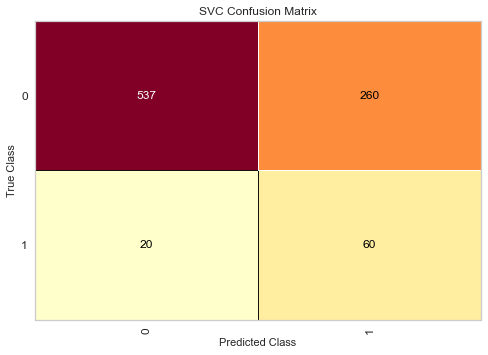

In [32]:
cm = ConfusionMatrix(cat_svc_model)
cm.fit(cat_X_train, cat_y_train)
cm.score(cat_X_test, cat_y_test)
cm.show()

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


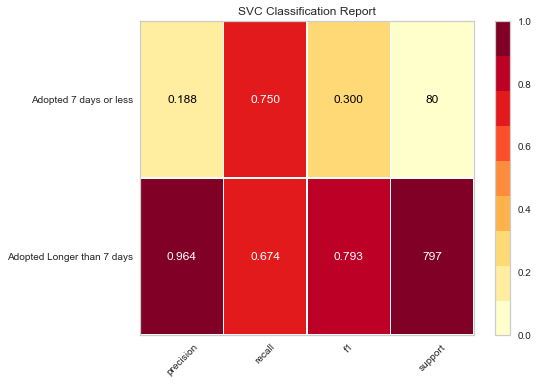

In [33]:
visualizer = ClassificationReport(cat_svc_model, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'], support=True)

visualizer.fit(cat_X_train, cat_y_train)       # Fit the visualizer and the model
visualizer.score(cat_X_test, cat_y_test)        # Evaluate the model on the test data
visualizer.show() 

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


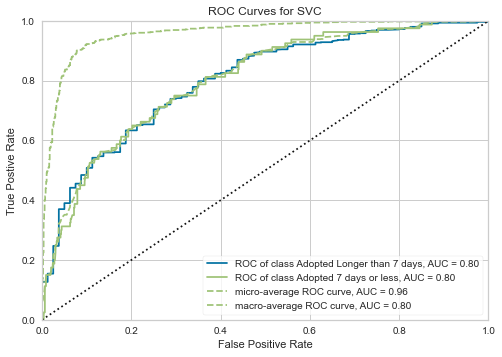

In [34]:
visualizer = ROCAUC(cat_svc_model, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'])

visualizer.fit(cat_X_train, cat_y_train)        # Fit the visualizer and the model
visualizer.score(cat_X_test, cat_y_test)        # Evaluate the model on the test data
visualizer.show() 

In [35]:
# Train model
cat_rf = RandomForestClassifier(class_weight='balanced', max_depth=3)
cat_rf_model = cat_rf.fit(cat_X_train, cat_y_train)
 
# Predict on training set
cat_rf_pred = cat_rf_model.predict(cat_X_test)

print( metrics.accuracy_score(cat_y_test, cat_rf_pred) )
print( metrics.recall_score(cat_y_test, cat_rf_pred) )

cat_rf_prob = cat_rf_model.predict_proba(cat_X_test)
cat_rf_prob = [p[1] for p in cat_rf_prob]
print( roc_auc_score(cat_y_test, cat_rf_prob) )



0.7525655644241733
0.8125
0.8259018193224593


In [36]:
print(metrics.classification_report(cat_rf_pred, cat_y_test) )

              precision    recall  f1-score   support

           0       0.75      0.98      0.85       610
           1       0.81      0.24      0.37       267

    accuracy                           0.75       877
   macro avg       0.78      0.61      0.61       877
weighted avg       0.77      0.75      0.70       877



C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


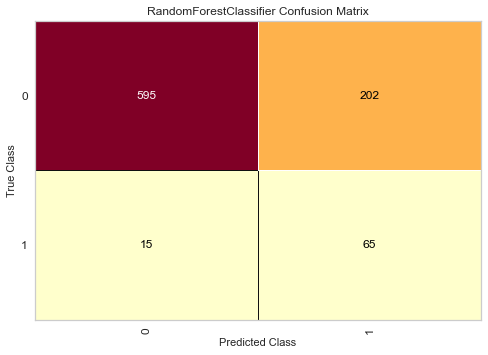

In [37]:
cm = ConfusionMatrix(cat_rf)
cm.fit(cat_X_train, cat_y_train)
cm.score(cat_X_test, cat_y_test)
cm.show()

In [38]:
#accuracy appears better but it is less accurate at predicting positives

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


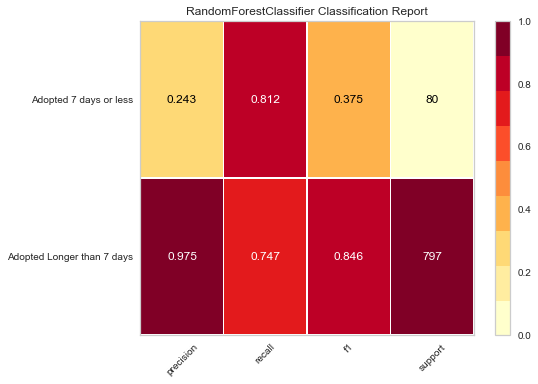

In [39]:
visualizer = ClassificationReport(cat_rf, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'], support=True)

visualizer.fit(cat_X_train, cat_y_train)       # Fit the visualizer and the model
visualizer.score(cat_X_test, cat_y_test)        # Evaluate the model on the test data
visualizer.show() 

C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


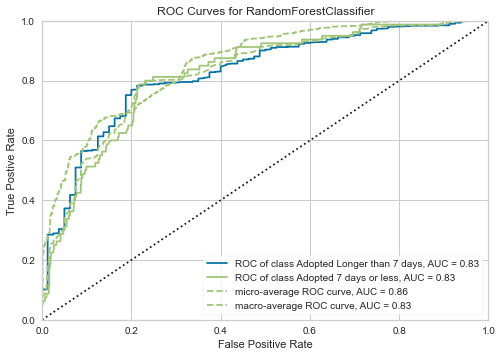

In [40]:
visualizer = ROCAUC(cat_rf, classes=['Adopted Longer than 7 days', 'Adopted 7 days or less'])

visualizer.fit(cat_X_train, cat_y_train)        # Fit the visualizer and the model
visualizer.score(cat_X_test, cat_y_test)        # Evaluate the model on the test data
visualizer.show() 

In [41]:
# Train model
cat_rf = RandomForestClassifier(class_weight='balanced', max_depth=5)
cat_rf_model = cat_rf.fit(cat_X_train, cat_y_train)
 
# Predict on training set
cat_rf_pred = cat_rf_model.predict(cat_X_test)

print( metrics.accuracy_score(cat_y_test, cat_rf_pred) )
print( metrics.recall_score(cat_y_test, cat_rf_pred) )

cat_rf_prob = cat_rf_model.predict_proba(cat_X_test)
cat_rf_prob = [p[1] for p in cat_rf_prob]
print( roc_auc_score(cat_y_test, cat_rf_prob) )



0.7708095781071835
0.725
0.8239648682559598


In [42]:
print(metrics.classification_report(cat_rf_pred, cat_y_test) )

              precision    recall  f1-score   support

           0       0.78      0.97      0.86       640
           1       0.72      0.24      0.37       237

    accuracy                           0.77       877
   macro avg       0.75      0.61      0.61       877
weighted avg       0.76      0.77      0.73       877



In [43]:
# Train model
cat_rf = RandomForestClassifier(class_weight='balanced', max_depth=8)
cat_rf_model = cat_rf.fit(cat_X_train, cat_y_train)
 
# Predict on training set
cat_rf_pred = cat_rf_model.predict(cat_X_test)

print( metrics.accuracy_score(cat_y_test, cat_rf_pred) )
print( metrics.recall_score(cat_y_test, cat_rf_pred) )

cat_rf_prob = cat_rf_model.predict_proba(cat_X_test)
cat_rf_prob = [p[1] for p in cat_rf_prob]
print( roc_auc_score(cat_y_test, cat_rf_prob) )



0.8323831242873432
0.5875
0.8187107904642409


In [44]:
print(metrics.classification_report(cat_rf_pred, cat_y_test) )

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       716
           1       0.59      0.29      0.39       161

    accuracy                           0.83       877
   macro avg       0.72      0.62      0.65       877
weighted avg       0.81      0.83      0.81       877



C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\rvick\Anaconda3\envs\R_Python\lib\site-packages\yellowbrick\model_selection\importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, usi

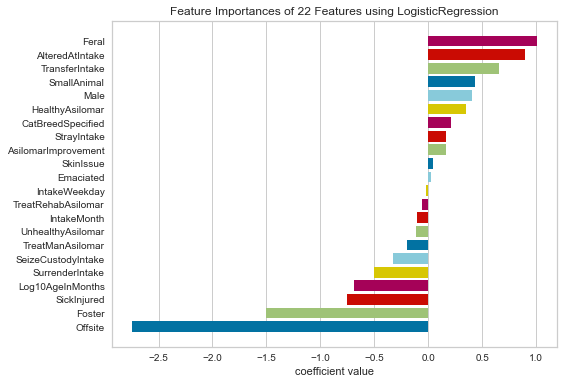

In [47]:
#Getting them from the random forest
from yellowbrick.model_selection import FeatureImportances

viz = FeatureImportances(LogisticRegression(),  relative=False)

# Fit and show the feature importances
viz.fit(cat_downsampled_features, cat_downsampled_target)
viz.show()